In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os
import pandas as pd

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from copy import deepcopy
import boto3
from botocore.handlers import disable_signing

import datetime as dt
import pytz

import scipy.signal as ss

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/botocore/awsrequest.py:624: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class HeadersDict(collections.MutableMapping):


In [2]:
fname = 'qvp_10deg_20150206.hdf5.npy'
d = np.load(fname, allow_pickle=True)

In [3]:
qvp_refl = d.item()['reflectivity']
qvp_time = d.item()['time']
qvp_height = d.item()['height']
qvp_range = d.item()['range']


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


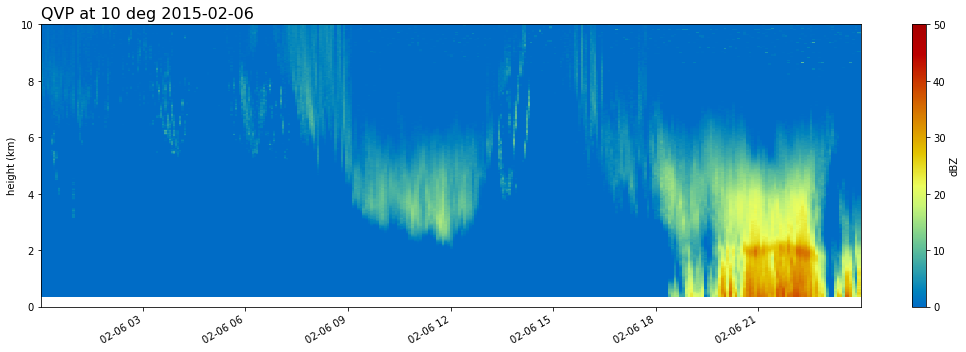

In [4]:
# Plot
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(111)
qmesh = plt.pcolormesh(qvp_time, qvp_height[-1]/1000., qvp_refl.T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('dBZ')
ax1.axis('tight')
ax1.set_ylabel('height (km)')
# Set up as dates
ax1.xaxis_date()
ax1.set_ylim((0,10))


titlestr = dt.datetime.strptime(fname, 'qvp_10deg_%Y%m%d.hdf5.npy')
timestr = dt.datetime.strftime(titlestr, '%Y%m%d')

ax1.set_title('QVP at 10 deg ' +str(titlestr.date()), loc='left', fontsize=16)

fig.autofmt_xdate()

savefname = 'QVP_sealand_sector_' + timestr + '.png'
plt.tight_layout()
plt.savefig(savefname)
#ax.set_title("QVP at 10 deg " +str(titlestr.date()))

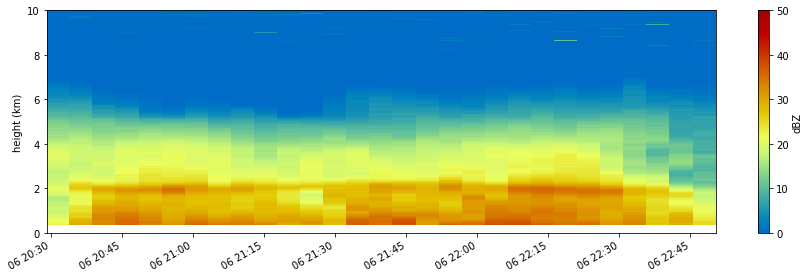

In [16]:
# Plot
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
qmesh = plt.pcolormesh(qvp_time[300:330], qvp_height[300:330][-1]/1000., qvp_refl[300:330].T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('dBZ')
ax1.axis('tight')
ax1.set_ylabel('height (km)')
# Set up as dates
ax1.xaxis_date()
ax1.set_ylim((0,10))


fig.autofmt_xdate()

# savefname = 'QVP_sealand_sector_' + timestr + '.png'
# plt.tight_layout()
# plt.savefig(savefname)
#ax.set_title("QVP at 10 deg " +str(titlestr.date()))

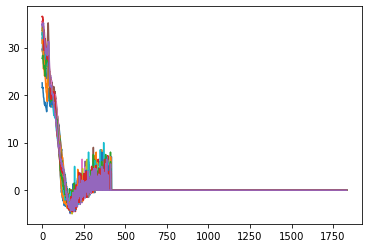

In [9]:
for i in range(300,315,1):
    plt.plot(qvp_refl[i])

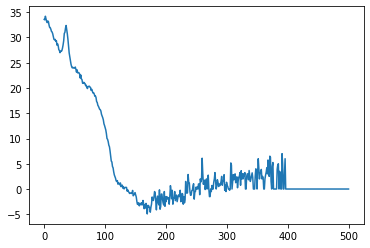

In [10]:
test_signal = qvp_refl[304][:500]
plt.plot(test_signal)

In [11]:
pk = ss.find_peaks(test_signal,prominence=5, width=3, height=10)

In [12]:
pk[0]

array([36])

In [13]:
test_signaly = test_signal[pk[0]]

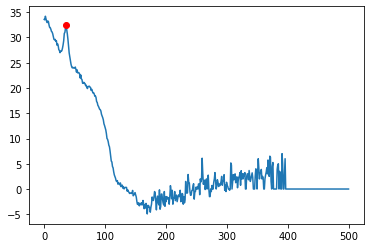

In [14]:
plt.plot(test_signal)
plt.plot(pk[0],test_signaly,'ro')

# Find peaks for a longer signal

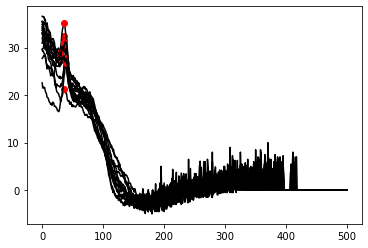

In [36]:
peaks = []
peaks_y = []

for i in range(300,315,1):
    test_signal = qvp_refl[i][:500]
    pk = ss.find_peaks(test_signal,prominence=3, width=3, height=15)
    peaks.append(pk[0])
    
    test_signaly = test_signal[pk[0]]
    peaks_y.append(test_signaly)
    
    plt.plot(test_signal,'k-')
    plt.plot(pk[0],test_signaly,'ro')

In [37]:
peaks

[array([36]),
 array([38]),
 array([36]),
 array([36]),
 array([36]),
 array([36]),
 array([36]),
 array([], dtype=int64),
 array([36]),
 array([], dtype=int64),
 array([38]),
 array([39]),
 array([30]),
 array([], dtype=int64),
 array([], dtype=int64)]

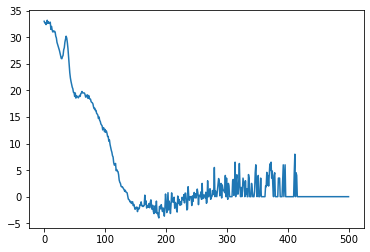

In [38]:
test_signal = qvp_refl[302][:500]
plt.plot(test_signal)

# Find peak values

In [46]:
qvp_height[302][pk[0]]

array([], dtype=float32)

In [54]:
peaks = []
peaks_y = []
ML_heights = []

for i in range(300,315,1):
    test_signal = qvp_refl[i][:500]
    pk = ss.find_peaks(test_signal,prominence=3, width=3, height=15)
    peaks.append(pk[0])
    
    test_signaly = test_signal[pk[0]]
    peaks_y.append(test_signaly)
    
    MLheight = qvp_height[i][pk[0]]
    try:
        ML_heights.append(MLheight[0])
    except IndexError:
        continue

In [55]:
ML_heights

[1942.0,
 2030.0,
 1942.0,
 1942.0,
 1942.0,
 1942.0,
 1942.0,
 1942.0,
 2030.0,
 2074.0,
 1680.0]

# Apply for entire day

In [59]:
peaks = []
peaks_y = []
ML_heights = []

for i in range(len(qvp_refl)):
    test_signal = qvp_refl[i][:500]
    pk = ss.find_peaks(test_signal,prominence=3, width=3, height=15)
    peaks.append(pk[0])
    
    test_signaly = test_signal[pk[0]]
    peaks_y.append(test_signaly)
    
    MLheight = qvp_height[i][pk[0]]
    try:
        ML_heights.append(MLheight[0])
    except IndexError:
        ML_heights.append(np.nan)

In [63]:
ML_heights[300:330]

[1942.0,
 2030.0,
 1942.0,
 1942.0,
 1942.0,
 1942.0,
 1942.0,
 nan,
 1942.0,
 nan,
 2030.0,
 2074.0,
 1680.0,
 nan,
 nan,
 1986.0,
 nan,
 2030.0,
 nan,
 nan,
 1942.0,
 1942.0,
 1898.0,
 1811.0,
 1898.0,
 nan,
 1854.0,
 1767.0,
 nan,
 nan]

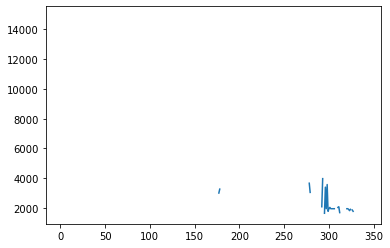

In [61]:
plt.plot(ML_heights)

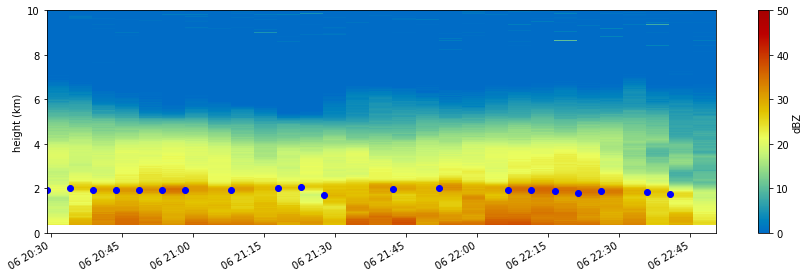

In [79]:
# Plot
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
qmesh = plt.pcolormesh(qvp_time[300:330], qvp_height[300:330][-1]/1000., qvp_refl[300:330].T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('dBZ')
ax1.axis('tight')
ax1.set_ylabel('height (km)')
# Set up as dates
ax1.xaxis_date()
ax1.set_ylim((0,10))

ax1.plot(qvp_time[300:330],np.array(ML_heights[300:330])/1000.,'bo')


fig.autofmt_xdate()

# savefname = 'QVP_sealand_sector_' + timestr + '.png'
# plt.tight_layout()
# plt.savefig(savefname)
#ax.set_title("QVP at 10 deg " +str(titlestr.date()))

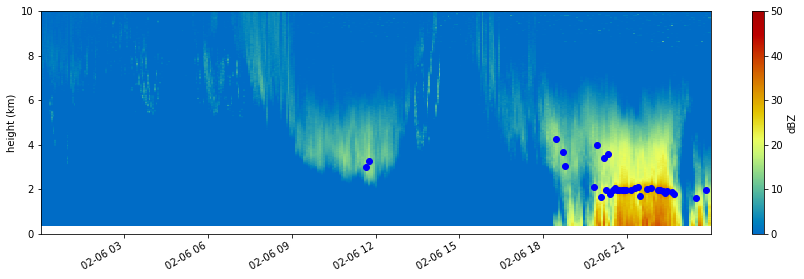

In [80]:
# Plot
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(211)
qmesh = plt.pcolormesh(qvp_time, qvp_height[-1]/1000., qvp_refl.T, 
                       vmin=0, vmax=50, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
ax1 = plt.gca()
cb = fig.colorbar(qmesh,ax=ax1)
cb.set_label('dBZ')
ax1.axis('tight')
ax1.set_ylabel('height (km)')
# Set up as dates
ax1.xaxis_date()
ax1.set_ylim((0,10))

ax1.plot(qvp_time,np.array(ML_heights)/1000.,'bo')


fig.autofmt_xdate()

# savefname = 'QVP_sealand_sector_' + timestr + '.png'
# plt.tight_layout()
# plt.savefig(savefname)
#ax.set_title("QVP at 10 deg " +str(titlestr.date()))